In [1]:
import os
import pathlib

In [2]:
"""
!ln -s /Users/shankar/dev/code/ds/object_detection/tools/devtools/tf_new/models/research/object_detection .
!ln -s models/research/object_detection
!ln -s models/official
!export PYTHONPATH=$PYTHONPATH:models/official
"""

'\n!ln -s /Users/shankar/dev/code/ds/object_detection/tools/devtools/tf_new/models/research/object_detection .\n!ln -s models/research/object_detection\n!ln -s models/official\n!export PYTHONPATH=$PYTHONPATH:models/official\n'

In [3]:
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    print(f"TF Models missing")

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

In [5]:
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [6]:
tf.__version__
%matplotlib inline

In [7]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def plot_detections(
    image_np, # uint8 numpy array with shape (img_height, img_width, 3)
    boxes, #  a numpy array of shape [N, 4]
    classes, #a numpy array of shape [N]. Note that class indices are 1-based, and match the keys in the label map.
    scores, # a numpy array of shape [N] or None.  If scores=None, then this function assumes that the boxes to be plotted are groundtruth boxes and plot all boxes as black with no classes or scores.
    category_index, # a dict containing category dictionaries (each holding category index `id` and category name `name`) keyed by category indices.
    figsize=(12, 16), 
    image_name=None
):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8
    )
    if(image_name):
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)
    

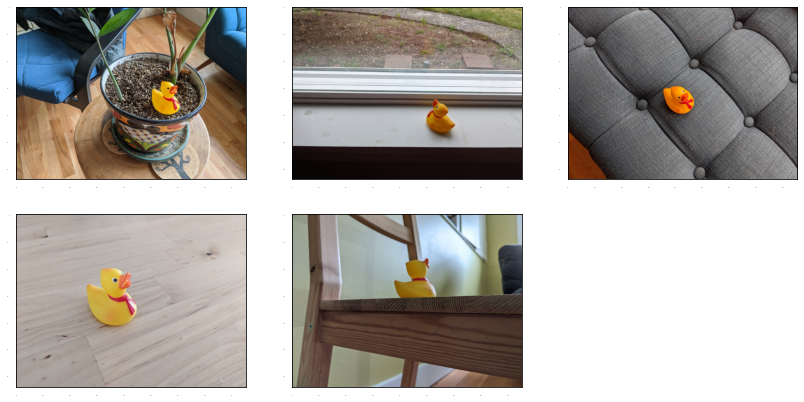

In [8]:
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
    image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))
    
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
    
plt.show()

### Annotate Images with Bounding Boxes

In [10]:
# gt_boxes = []
# colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [11]:
gt_boxes = [
    np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
    np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
    np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
    np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
    np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

### Prepare Data
- Convert class labels to 1-HOT
- Convert everythign to tensors
- Label id offset shifts all classes by a certain number of indices
- Model received 1-hot labels where non-background classes start counting at the zeroth index
- This is automatically handled in training boundaries

In [12]:
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(
        tf.expand_dims(tf.convert_to_tensor(
            train_image_np, dtype=tf.float32
        ), axis=0)
    )
    gt_box_tensors.append(
        tf.convert_to_tensor(
            gt_box_np, dtype=tf.float32
        )
    )
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset
    )
    gt_classes_one_hot_tensors.append(
        tf.one_hot(zero_indexed_groundtruth_classes, num_classes)
    )
print('Done Prepping Data')

Done Prepping Data


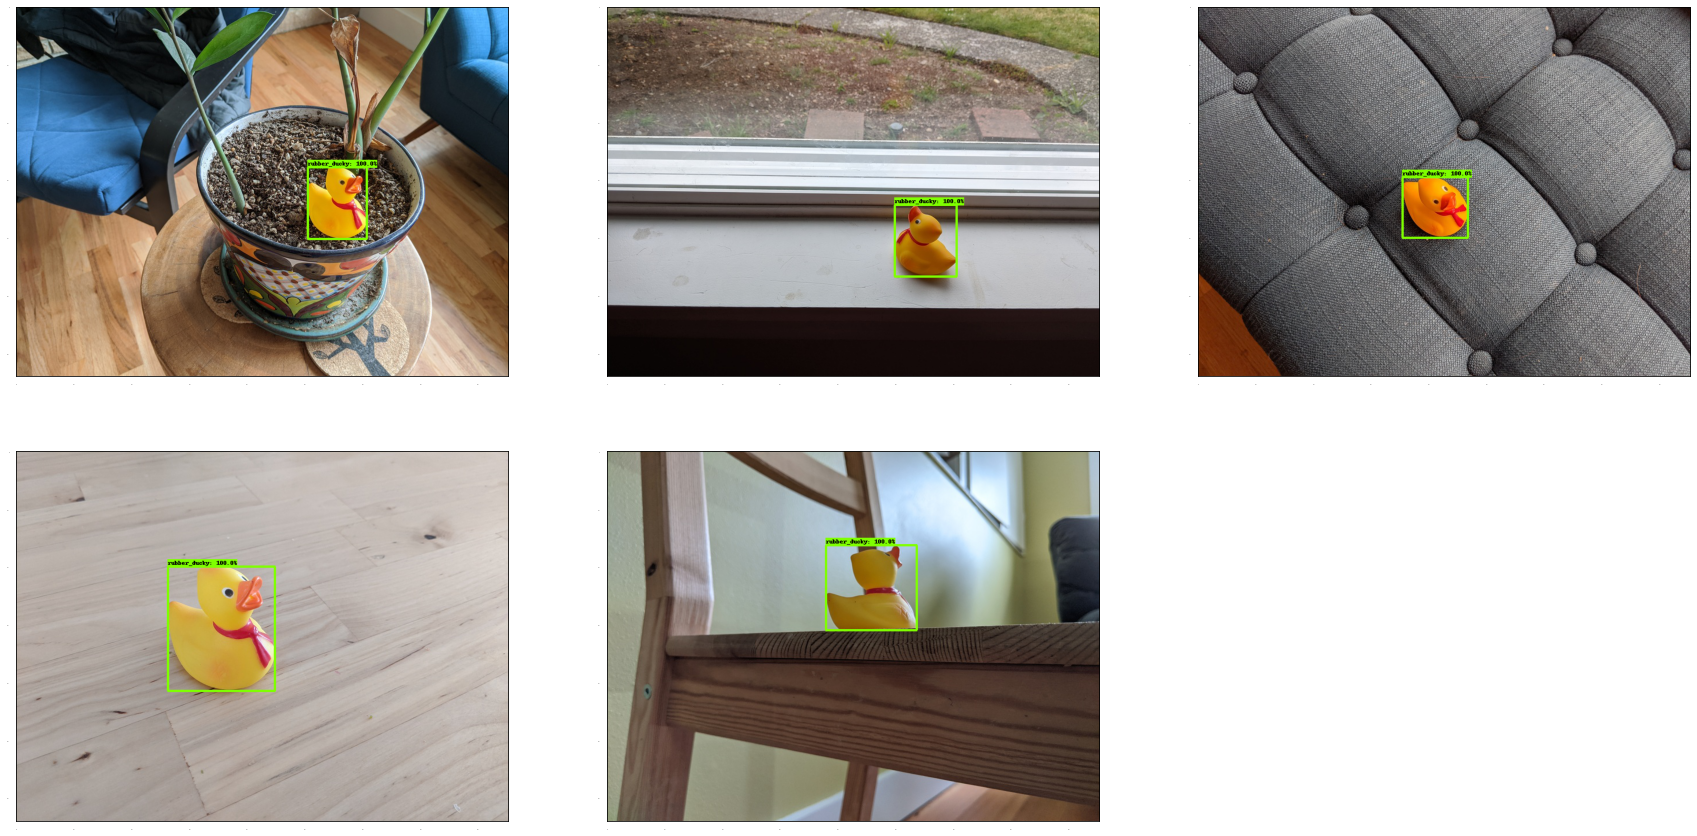

In [13]:
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, 
        category_index
    )
plt.show()

In [15]:
tf.keras.backend.clear_session()
print("Building model and restoring weights for fine-tuning...", flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/Users/shankar/dev/code/ds/object_detection/data/models/resnet/ssd_resnet50_tpu/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

Building model and restoring weights for fine-tuning...


In [16]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config=model_config,
    is_training=True
)

- Set up object-based checkpoint restore
- RetinaNet has two prediction
- `heads` --- one for classification and one for regression
- We will restore the box regression head but initialize the classification head from scratch
- We show the omission below by commenting out the line that we would add if we wanted to resotre both heads

In [18]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    
)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor
)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [19]:
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print("Weights Restored!")

Weights Restored!


In [20]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
]

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [23]:
# Set up forward+backward pass for a single train step
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    
    @tf.function
    def train_step_fn(
        image_tensors, 
        groundtruth_boxes_list, 
        groundtruth_classes_list
    ):
        
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )
        
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat([
                detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors
            ], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune
)

print('Start fine-tuning', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]
    
    # Do data augmentation if required
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]
    
    # Training Step (forward pass + backward pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    
    if(idx % 10 == 0):
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)
print('Done fine-tuning')

Start fine-tuning
batch 0 of 100, loss=1.2518526
batch 10 of 100, loss=0.1989965
batch 20 of 100, loss=0.026254723
batch 30 of 100, loss=0.01255968
batch 40 of 100, loss=0.006154362
batch 50 of 100, loss=0.0049150293
batch 60 of 100, loss=0.0039024262
batch 70 of 100, loss=0.0037153917
batch 80 of 100, loss=0.0032247212
batch 90 of 100, loss=0.0029326812
Done fine-tuning


### Load Test Images and Run Inference

In [26]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
    image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
    test_images_np.append(
        np.expand_dims(
            load_image_into_numpy_array(image_path),
            axis=0
        )
    )

In [27]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

In [28]:
# First frame will trigger tracing of the tf.function, which will 
# take some time, after which inference should be fast

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    
    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index,
        figsize=(15, 20),
        image_name="gif_frame_" + ('%02d' % i) + ".jpg"
    )

In [31]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'
filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)
    
imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)
#display(IPyImage(open(anim_file, 'rb').read()))